# Market domination predictions with N-BEATS

In [12]:
!pip3 install -qU darts scipy torch pandas matplotlib requests


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.604    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MP

Epoch 199: 100%|██████████| 13/13 [00:02<00:00,  5.61it/s, train_loss=0.00354]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s, train_loss=0.00354]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.71it/s]


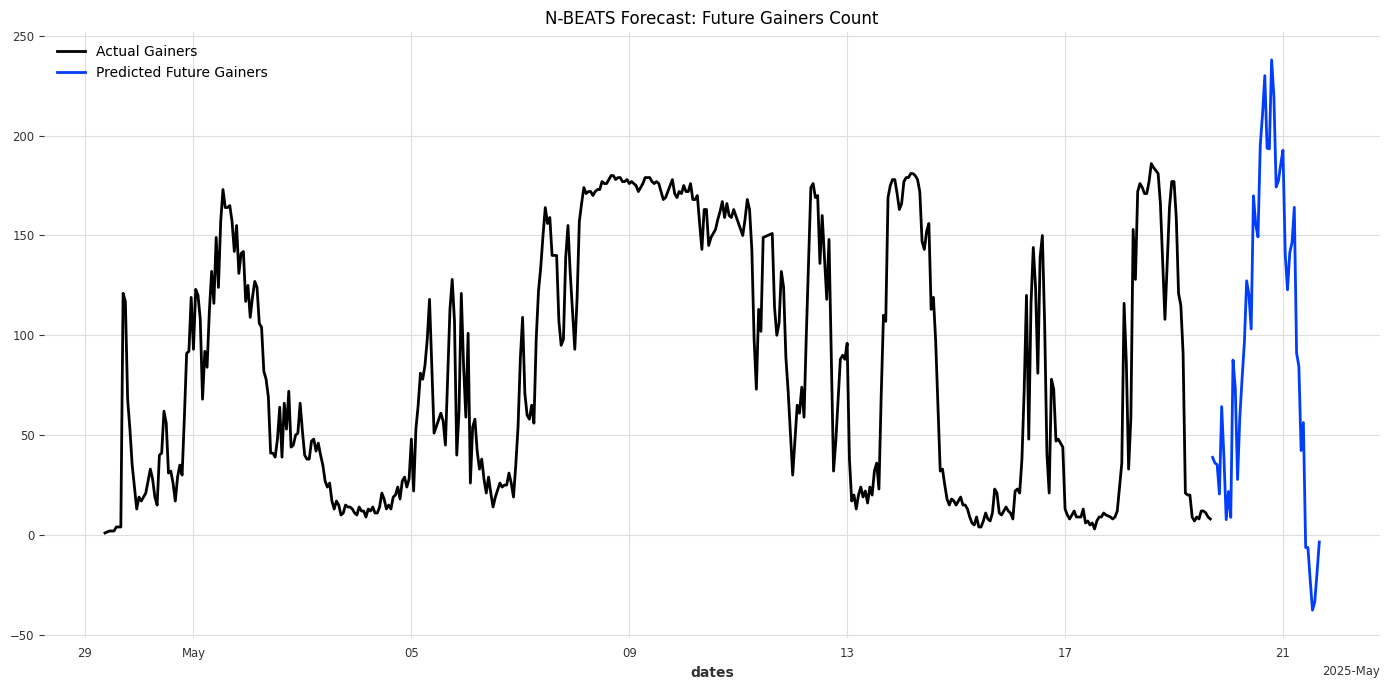

In [13]:
# Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Create TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['gainers_count'],
    fill_missing_dates=True,
    freq="h"
)

# Normalize and fill
scaler = Scaler()
filler = MissingValuesFiller()
series = filler.transform(series, method="linear")
series_scaled = scaler.fit_transform(series)

# input_chunk_length can't be increased because data needs to be 500+
input_chunk_length = 240
forecast_horizon = 48

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=200,
    # smaller means more frequent weight updates
    batch_size=16,
    # keep constant for consistency across repeated runs
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
# Remove verbose for production
model.fit(series_scaled, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Plot
# To remove in production
plt.figure(figsize=(14, 7))
series.plot(label="Actual Gainers")
future_forecast_orig.plot(label="Predicted Future Gainers")
plt.title("N-BEATS Forecast: Future Gainers Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# With Box-Cox transformation

In [14]:
# Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim
from scipy.stats import boxcox
import numpy as np

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype(np.float32)
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype(np.float32)
df['gainers_count'] = df['gainers_count'].astype(np.float32)
df['losers_count'] = df['losers_count'].astype(np.float32)
df["total_volume"] = df["total_volume"].astype(np.float32)


# Create TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['gainers_count'],
    fill_missing_dates=True,
    freq="h"
)

filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")


# Apply Box-Cox transformation
# Box-Cox requires positive values, so add a small constant if necessary
# Also store the lambda parameter returned by boxcox for inverse transformation
series_filled_values = series_filled.values().flatten()
if np.min(series_filled_values) <= 0:
    series_filled_values = series_filled_values + np.abs(np.min(series_filled_values)) + 1e-6

series_boxcox, lambda_param = boxcox(series_filled_values)
series_boxcox = TimeSeries.from_times_and_values(series.time_index, series_boxcox, freq=series.freq)


# Normalize and fill
scaler = Scaler()
series_scaled = scaler.fit_transform(series_boxcox)
series_scaled = filler.transform(series_scaled, method="linear")

# Parameters
input_chunk_length = 240
forecast_horizon = 24

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=100,
    # smaller means more frequent weight updates
    batch_size=16,
    # keep constant for consistency across repeated runs
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
# Remove verbose for production
model.fit(series_scaled, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Plot
# To remove in production
plt.figure(figsize=(14, 7))
series.plot(label="Actual Gainers")
future_forecast_orig.plot(label="Predicted Future Gainers")
plt.title("N-BEATS Forecast: Future Gainers Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.